Primer ilustruje rad sa rekurentnim neuronskim mrezama u analizi vremenskih serija. 

Datoteka **jena_climate_2009_2016.csv** sadrzi podatke meteoroloske stanice Maks Plank instituta u Jeni. U periodu od 2009. godine do 2016. godine na svakih 10 minuta merene su 14 razlicitih vrednosti kao sto su temperatura, atmosferski pritisak, vlaznost vazduha, pravac vetra, ... 

Potrebno je osmisliti model koji ce predvidjati vrednosti temperature u toku jednog dana na osnovu nekoliko prethodnih merenja.

In [91]:
import os
import numpy as np 
from matplotlib import pyplot as plt

In [92]:
from keras.preprocessing import sequence
from keras.layers import Embedding, Dense , LSTM, GRU
from keras.models import Sequential
import keras.backend as K

#### Ucitavanje i analiza raspolozivih podataka. 

In [93]:
data_directory = './datasets/'
file_name = os.path.join(data_directory, 'jena_climate_2009-2016.csv')
f = open(file_name, 'r')
data = f.read()
f.close()

Ovako procitani podaci su u tekstualnoj formi.

In [94]:
all_lines = data.split('\n')
number_of_lines = len(all_lines)
number_of_lines

420552

In [95]:
# Prva linija sadrzaja je zaglavlje sa imenima kolona. 
header = all_lines[0]
print(header)

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"


In [96]:
header = header.split(',')

In [97]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [98]:
len(header)

15

In [99]:
# Preostale linije sadrzaja su linije sa podacima. 
lines = all_lines[1:]

In [100]:
# Primer linije sa podacima.
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

Podatke je potrebno prebaciti u numericku formu.

In [101]:
# Informacija o datumu i vremenu merenja se ignorise.
number_of_features = len(header)-1
number_of_mesurements = len(lines)
float_data = np.zeros((number_of_mesurements, number_of_features))

In [102]:
for i, line in enumerate(lines):
    values = [ float(m) for m in line.split(',')[1:]]
    float_data[i, :] = values

In [103]:
float_data.shape

(420551, 14)

Vizuelizacija podataka.

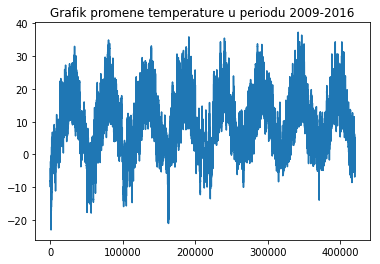

In [104]:
temp = float_data[:, 1]
plt.title('Grafik promene temperature u periodu 2009-2016')
plt.plot(range(0, len(lines)) , temp)

In [105]:
# Merenja su vrsena na svakih 10 minuta.
# To je 6 puta na sat vremena.
# To je 6X24 = 144 puta u toku dana. 

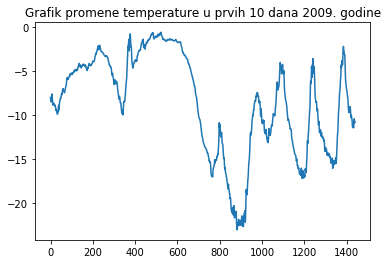

In [106]:
plt.title("Grafik promene temperature u prvih 10 dana 2009. godine")
plt.plot(range(0, 1440) , temp[0:1440])

Potrebno je kreirati model koji ce predvidjati vrednosti temperature u toku jednog dana (144 vrednosti) na osnovu svakog sestog merenja protekllih 720 merenja. Motivacija za preskakanje nekih vrednosti prethodnih merenja je nepromenljivost temperature u kratkim vremenskim periodima kao sto je 10 minuta.   

In [107]:
# broj prethodnih merenja 
lookback = 720 

# frekvencija sa kojom ce se uzimati prethodna merenja
steps = 6 

# udaljenost trenutka u buducnosti u kojem treba dati ocenu merenja, konkretno, temperature. 
delay = 144 

#### Generisanje skupova za treniranje, validaciju i testiranje.

Skupovi za treniranje, validaciju i testiranje treba da sadrze vrednosti merenja, sa odgovarajucim vremenskim razmakom, i temperature koje su im odgovarale u trenucima u buducnosti. Da bi se odrzala disjunktnost ovih skupova, merenja ce biti birana iz razlicitih opsega vrednosti odredjenih svojom donjom i gornjom granicom. Merenja u skupu za treniranje treba da prethode merenjima u validacionom skupa, a ona zajedno, treba da prethode merenjima u skupu za testiranje. 

Nadalje sledi funkcija koja vraca odgovarajuce generatore vrednosti.

In [108]:
# data - zadati podaci
# lookback - broj merenja iz proslosti koje treba uzeti u obzir
# delay - broj merenja u buducnosti za koje treba dati ocene merenja
# min_index, max_index - vrednosti koje predstavljaju donju i gornju granicu merenja 
# shuffle - indikator mesanja podataka
# batch_size - velicina skupa podataka koje treba generisati
# step - korak sa kojim ce biti birana merenja iz proslosti

def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):       
        
        # za slucaj da max_index nije zadat, bira se vrednost koja garantuje izbor odgovarajuceg broj predikcija
        if max_index is None: 
            max_index = len(data)- delay -1
            
            
        # indeks i oznavacava minimalni indeks merenja od kojeg se mogu birati podaci za zeljeni skup 
        # izraz garantuje da postoji odgovarajuci broj merenja u proslosti
        
        i = min_index + lookback 
        
        # U smernicama Keras biblioteke za implementaciju generatorske funkcije stoji: 
        # The generator is expected to loop over its data indefinitely.
        while True: 
            
            
            # generise se odgovarajuci skup indeksa vrednosti merenja
            if shuffle: 
                rows = np.random.randint(low = i, high=max_index, size= batch_size)
        
            else: 
                if i + batch_size >=max_index:
                    i = min_index + lookback
                rows = np.arange(i, min(i + batch_size, max_index))
                
                i += len(rows)

            # samples ce biti skup odgovarajucih merenja
            samples = np.zeros((len(rows), lookback//step, float_data.shape[-1]))
            
            # targets ce biti skup odgovarajucih predikcija 
            targets = np.zeros(len(rows))
            
            for j, row in enumerate(rows):
                indexes = range(rows[j]-lookback, rows[j], step)
                samples[j] = data[indexes]
                targets[j] = data[rows[j] + delay][1]
    
    
            yield samples, targets

In [109]:
# fiksira se broj instanci skupa za treniranje
number_of_training_data = 200000

In [ ]:
# vrsi se standardizacija podataka 
mean = float_data[: number_of_training_data].mean(axis=0)
float_data -= mean
std = float_data[: number_of_training_data].std(axis=0)
float_data /= std

In [1]:
# fiksira se velicina skupova koje treba generisati
batch_size = 32

In [60]:
# generisu se odgovarajuci skupovi
train_gen = generator(float_data, lookback, delay, min_index = 0, max_index = 200000, shuffle = True, batch_size = batch_size, step = steps)
val_gen = generator(float_data, lookback, delay, min_index = 200001, max_index = 300001, shuffle = True, batch_size = batch_size, step = steps)
test_gen = generator(float_data, lookback, delay, min_index = 300001, max_index=None, shuffle = True, batch_size = batch_size, step = steps)

In [61]:
# odredjuje se broj validacionih i test koraka
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

#### GRU (eng. Gated Recurrent Units)

GRU celije predstavljaju pojednostavljenje LSTM rekurentnih celija kod kojih su objedinjeni koraci azuriranja i zaboravljanja. 

In [ ]:
model = Sequential()
model.add(GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

In [63]:
model.compile(optimizer='rmsprop', loss='mae')

*fit_generator* je metoda ekvivalentna *fit* metodi uz izuzetak koriscenja generatorskih funkcija za kreiranje paketica za treniranje. Argumentom *steps_per_epoch* se kontrolise koliko obradjenih paketica traje jedna epoha. Ova metoda koristi generatorske funkcije i za kreiranje paketica za validaciju. Argument *validation_steps* kontrolise koliko validacionih paketica treba generisati na nivou jedne epohe. 

Vise o funkciji se moze pronaci u zvanicnoj dokumentaciji: 
https://keras.io/models/sequential/#fit_generator

In [64]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, \
                              validation_data=val_gen, validation_steps=val_steps )

Epoch 1/20
500/500 [==============================] - 253s 507ms/step - loss: 0.3136 - val_loss: 0.2845
Epoch 2/20
500/500 [==============================] - 257s 514ms/step - loss: 0.2917 - val_loss: 0.2719
Epoch 3/20
500/500 [==============================] - 254s 508ms/step - loss: 0.2895 - val_loss: 0.2720
Epoch 4/20
500/500 [==============================] - 257s 514ms/step - loss: 0.2837 - val_loss: 0.2683
Epoch 5/20
500/500 [==============================] - 255s 510ms/step - loss: 0.2835 - val_loss: 0.2736
Epoch 6/20
500/500 [==============================] - 254s 508ms/step - loss: 0.2773 - val_loss: 0.2650
Epoch 7/20
500/500 [==============================] - 258s 516ms/step - loss: 0.2774 - val_loss: 0.2752
Epoch 8/20
500/500 [==============================] - 263s 527ms/step - loss: 0.2705 - val_loss: 0.2766
Epoch 9/20
500/500 [==============================] - 263s 525ms/step - loss: 0.2734 - val_loss: 0.2758
Epoch 10/20
500/500 [==============================] - 256s 512m

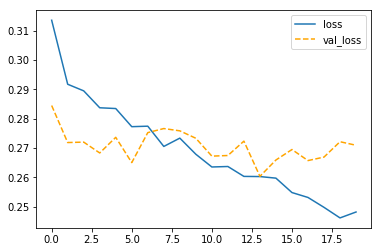

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0, 20)
plt.plot(epochs, loss, label ='loss')
plt.plot(epochs, val_loss, label='val_loss', linestyle ='--', color='orange')
plt.legend(loc='best')

In [87]:
min_val_loss = np.min(val_loss)
print(min_val_loss)

0.26033139565


Najmanja greska na validacionom skupu je oko 0.26 ~ 2.35 stepeni.

**Zadatak za vezbu:**

* Kako se ponasa mreza ukoliko se doda *recurrent_dropout* argument sa vrednoscu 0.2 GRU sloju?

* Uporediti dobijene rezultate sa rezultatima koje generise mreza ciji su ulazi prethodna merenja (njih lookback//steps), koja ima jedan gusti sloj velicine 32 neurona i izlazni sloj koji daje vrednost temperature.  

* Uporediti dobijene rezultate sa mrezom koja umesto GRU sloja koristi LSTM sloj.


** Koriscena literatura: **

* Python podsetnik na generatore: https://wiki.python.org/moin/Generators
* knjiga: Deep Learning with Python, Francois Chollet
* Github repozitorijum: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb